In [1]:
import os
import torch

In [2]:
names = open("./names.txt", "r+").read().splitlines()

In [3]:
chars = sorted(list(set("".join(names))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i:s for s, i in stoi.items()}

In [41]:
block_size = 5

X, Y = [], []

for name in names:
    context = [0] * block_size
    for c in name + ".":
        ix = stoi[c]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]        

X = torch.tensor(X)
Y = torch.tensor(Y)

In [47]:
def build_dataset(names):

    X, Y = [], []
    
    for name in names:
        context = [0] * block_size
        for c in name + ".":
            ix = stoi[c]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]        
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(42)
random.shuffle(names)
n1 = int(0.8 * len(names))
n2 = int(0.9 * len(names))
Xtr, Ytr = build_dataset(names[:n1])
Xdev, Ydev = build_dataset(names[n1:n2])
Xtest, Ytest = build_dataset(names[n2:])

In [48]:
import torch.nn.functional as F
embed_size = 10 #embedding size
vocab_size = len(stoi) # vocabulary size
n = Y.shape[0] # the number of examples
h_size = 100 # dimension of the hidden layer
lr = 0.01
C = torch.randn((vocab_size, embed_size), requires_grad=True)
W1 = torch.randn((block_size * embed_size, h_size), requires_grad=True)
b1 = torch.randn(h_size, requires_grad=True)
W2 = torch.randn((h_size, vocab_size), requires_grad=True)
b2 = torch.randn(vocab_size, requires_grad=True)
params = [C, W1, b1, W2, b2]

In [49]:
#lre = torch.linspace(-3, 0, 1000)
#lrs = 10 ** lre

In [50]:
from tqdm import tqdm

In [56]:
stepis = []
lossi = []

for i in tqdm(range(200000)):
    ix = torch.randint(0, Xtr.shape[0], (32, )) # minibatch idx
    X_batch = Xtr[ix]
    Y_batch = Ytr[ix]
    # Forward
    E = C[X_batch]
    h = E.view(-1, block_size * embed_size) @ W1 + b1
    h = torch.tanh(h)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y_batch)

    for p in params:
        p.grad = None # zero grad
    loss.backward() # backward pass
    for p in params:
        p.data -= 0.01 * p.grad
    stepis.append(i)
    lossi.append(loss.log10().item())
print(loss.item())

100%|████████████████████| 200000/200000 [01:44<00:00, 1912.23it/s]

1.8663408756256104


In [57]:
from matplotlib import pyplot as plt

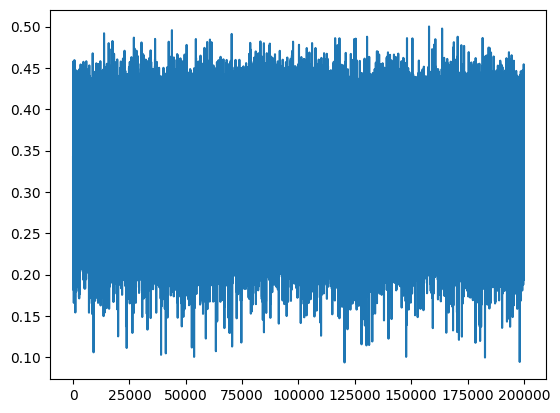

In [58]:
plt.plot(stepis, lossi)

In [59]:
E = C[Xdev]
h = E.view(-1, block_size * embed_size) @ W1 + b1
h = torch.tanh(h)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
print(loss.item()) # total loss

2.1690778732299805


In [60]:
# sampling

In [113]:
def sample():
    context = [0] * block_size
    context = context
    res = ""
    while True:
        E = C[context]
        h = E.view(-1, block_size * embed_size) @ W1 + b1
        h = torch.tanh(h)
        logits = h @ W2 + b2
        probs = F.softmax(logits)
        ix = torch.multinomial(probs, num_samples=1).item()
        if ix == 0:
            break
        res += itos[ix]
        context = context[1:] + [ix]
    return res

In [122]:
sample()

/var/folders/yw/_q0c7_715496fszpj84k_tb00000gn/T/ipykernel_90696/159107022.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(logits)


'roris'